# Feature Construction
Generate the class values, i.e. the y for the data. Construct features

## Parameters
Here, all parameters of the notebook are set

In [46]:
#Load stock market files 
#filename = '01_Source/Source_OMX1986-2019.CSV'
filename = '01_Source/Source_OMX2017-2019_testset.CSV'

#filedataresultdirectory = "02_Training_Data"
filedataresultdirectory = "03_Test_Prepared_Data"
#filenameprefix = "omxs30"
filenameprefix = "omxs30_test"

dataset_filename = filedataresultdirectory + "/" + filenameprefix + "_dataset.csv"
#X_filename = filedataresultdirectory + "/" + filenameprefix + "_X_.csv"
#y_filename = filedataresultdirectory + "/" + filenameprefix + "_y_" + yName + ".csv"
ylabel_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + "_labels.csv"
source_filename = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + ".csv"

#Allow cropping of data, which are longer than moving averages in the future. For training data, this value shall be 
#true to not make false values. For the test values, which do not use any y values, the value shall be false.
cut_data = False

## Load Raw Data
Stock data will be loaded, train and test values will be calculated to be used as Y values for the system

<IPython.core.display.Javascript object>


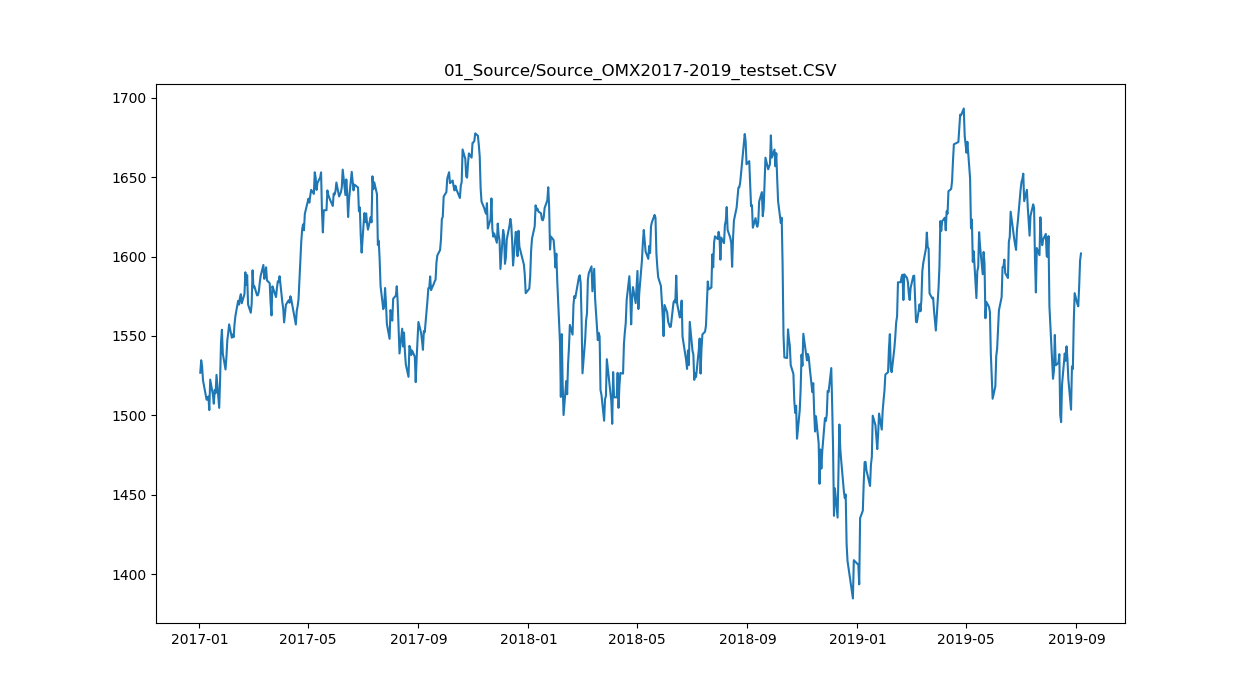

In [47]:
%matplotlib notebook

import pandas as pd
import numpy as np
# import pandas_datareader as datareader
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
#from matplotlib.finance import candlestick_ohlc
# from mpl_finance import candlestick_ohlc

#%matplotlib inline
#%matplotlib notebook
#%matplotlib ipympl

df = pd.read_csv(filename, sep=';')
df.index.name = "id"
df.columns = ['Time', 'High', 'Low', 'Close']
df['Time'] = pd.to_datetime(df['Time'])
df['Time'].apply(mdates.date2num)
#df.head()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.title(filename)
plt.show()

### Time Series Autocorrelation Matrix

In [48]:
# If time series are used, apply auto correlation to see how many values are relevant for moving averages

## Class Generation

### Calculate Tops and Bottoms

In [49]:
m=df.shape[0]
factor = 10000000
topsTemp = np.zeros([m, 4]);
topsTemp
bottomsTemp = np.ones([m, 4])*factor;
bottomsTemp
#close=df['Close']
#close

array([[10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       ...,
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.],
       [10000000., 10000000., 10000000., 10000000.]])

In [50]:
# Get tops and bottoms from the chart
#Parameter
maxDecline = 0.02
maxIncrease = 0.02
factor = 10000000

#Format: Time, High, Low, Close
m=df.shape[0]

topsTemp = np.zeros([m, 4])
bottomsTemp = np.ones([m, 4])*factor

high=df['High']
low=df['Low']
close=df['Close']

#Run 1 for the rough tops and bottoms
for i, data in enumerate(df.values):
    #Get top
    if i>3 and i<m-3:
        #Decline close >2% from top high
        decline = (high[i] - min(close[i+1:i+2]))/high[i];
        if decline > maxDecline or high[i]==max(high[i-3:i+3]):
            #Top found
            topsTemp[i, 1]=high[i];
            #print("Top found at i={} value={}".format(i, high[i]));
    
    #%Get bottom
    if i>3 and i<m-3:
    #    %Decline close >2% from top high
        increase = (low[i] - max(close[i+1:i+2]))/low[i];
        if increase > maxIncrease or low[i]==min(low[i-3:i+3]):
            #Top found
            bottomsTemp[i, 1]=low[i];
            #print("Bottom found at i={} value={}".format(i, low[i]));

print("{} tops, {} bottoms found.".format(sum(topsTemp[:, 1]>0), sum(bottomsTemp[:, 1]<factor)));

#%Run 2 for exacter tops and bottoms
iTop = topsTemp[:,1];
iBottom = bottomsTemp[:,1];
for i, data in enumerate(df.values):
    #Tops
    if i>20 and i<m-20:
        if iTop[i]>0 and max(iTop[i-15:i+15])<=iTop[i]:
            topsTemp[i, 2]=iTop[i];
            #%fprintf("Intermediate top found at i=%i value=%.0f\n", i, iTop(i));
    
        if iBottom[i]<factor and min(iBottom[i-15:i+15])>=iBottom[i]:
            bottomsTemp[i, 2]=iBottom[i];
            #%fprintf("Intermediate bottom found at i=%i value=%.0f\n", i, iBottom(i));

bottomsTemp[bottomsTemp==factor]=0
bottoms=bottomsTemp[:, 2]
tops=topsTemp[:, 2]
print("Reduced to {} tops and {} bottoms.".format(sum(tops[:]>0), sum(bottoms[:]>0)));

116 tops, 78 bottoms found.
Reduced to 18 tops and 16 bottoms.


In [51]:
#topsTemp[topsTemp[:,1]>0]

In [52]:
#bottomsTemp[0:10,:]

<IPython.core.display.Javascript object>


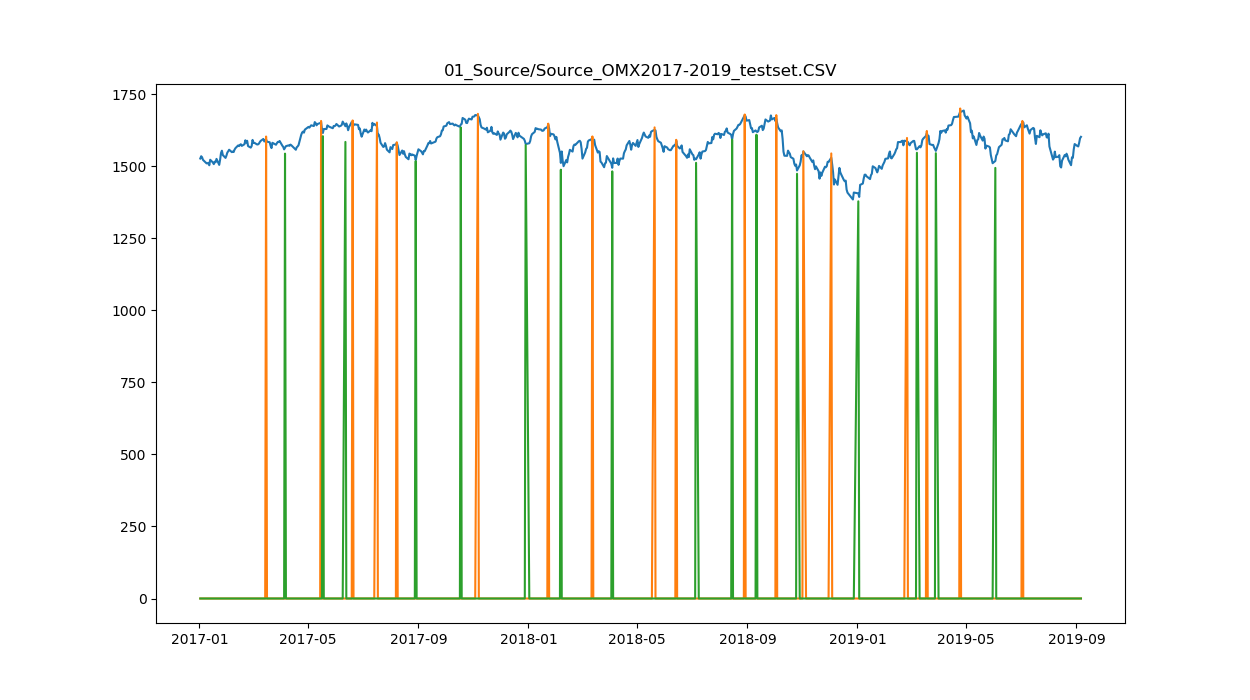

In [53]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'], tops[:])
plt.plot(df['Time'], bottoms[:])
plt.title(filename)
plt.show()

In [54]:
#Calculate the latest single event from a list of [0 0 0 0 2 0 0 1 0]->[0 0 0 0 2 2 2 2 1 1]
def calculateLatestEvent(eventList):
    previousItem=0;
    result = np.zeros(eventList.shape[0])
    for i in range(len(eventList)):
        if eventList[i]!=previousItem and eventList[i]!= 0:
            result[i]=eventList[i]
            previousItem=eventList[i]
        else: 
            result[i]=previousItem
    return result

latestBottoms = calculateLatestEvent(bottoms)
latestTops = calculateLatestEvent(tops)

In [55]:
#Calculate varios MA
#mov = pd.Series(np.arange(0, 100, 1), name='test')
#print(mov)
#Moving Average 
# mov: close
# n: Number of samples
# shift: shift of the window. shift < 0 future, shift > 0 history
def MA(mov, n, shift):  
    MA = mov.rolling(n).mean()
    #print(MA)
    df=pd.DataFrame(MA)
    df.columns = ['SMA' + str(n) + 'shift' + str(shift)]
    shiftedMA = df.shift(shift)
    
    return shiftedMA

In [56]:
ma50Future = MA(close, 50, -50)

In [57]:
#Use Lowess to create a smoothed trend as an y value

from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from scipy.ndimage.interpolation import shift

#Fraction for the lowess smoothing function
frac=300/len(df['Close'])
filtered = lowess(df['Close'], df['Time'], frac=frac)
#Calculate the dlowess/dt to see if it is raising or declining
shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
pos_trend = shiftCol>0
print(pos_trend[0:5])

[False  True  True  True  True]


C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


### Calculate the Y values for 1d, 5d, 20d and the Long Trend

In [58]:
#Calculte the 1d trend

high=df['High']
low=df['Low']
close=df['Close']

y1day=np.zeros(m)
#Calculate the 5d trend
y5day=np.zeros(m)
#20d trend
y20day=np.zeros(m)
#long term trend
ylong=np.zeros(m)
signalLong=0;

for i in range(m-50):
    if close[i+1]>close[i]:
        y1day[i]=1
    
    if close[i+5]>close[i]:
        y5day[i]=1;
    
    if close[i+20]>close[i]:
        y20day[i]=1;
    
    #long term
    #Trigger buy
    if pos_trend[i] == True and close[i]>latestTops[i]:
        signalLong=1;
    elif close[i]<latestBottoms[i] and pos_trend[i] == False:
        signalLong=0;
    
    #old
    #if close[i] < ma50Future.iloc[i,0] and close[i]>latestTops[i]:
    #    signalLong=1;
    #elif close[i]<latestBottoms[i] and close[i] > ma50Future.iloc[i,0]:
    #    signalLong=0;
        
    if signalLong==1:
        ylong[i] = 1;
    else:
        ylong[i] = 0;

print("y1day", sum(y1day))
print("y5day", sum(y5day))
print("y20day", sum(y20day))
print("ylong", sum(ylong))
print("Generated trends 1d, 5d, 20d, long.")

y1day 327.0
y5day 358.0
y20day 333.0
ylong 259.0
Generated trends 1d, 5d, 20d, long.


In [59]:
#Clean bad signals 1
previousSignalCount = sum(y1day)
for i in range(m-50):
    #If the signal is only valid for one or 2 days the signal was bad and
    #noisy. Only if the signal is valid for 3 days, it can be consideres as
    #a real signal
    if np.mean(y1day[i:i+3])<0.75:
        y1day[i]=0

print("Previous signal count y1day={}. New signal count={}".format(previousSignalCount, sum(y1day)))
print("Cleaned bad signals 1");

Previous signal count y1day=327.0. New signal count=105.0
Cleaned bad signals 1


In [60]:
#Clean bad signals 2, filter single days, enhance trend
print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))

#for i in range(m-50):
    # short term +1d
    #if i>1 and y1day[i-1]==0 and y1day[i+1]==0:
    #    y1day[i]=0;
    
    #long term, remove all values < 5 days to remove noise
    #use sliding window
    #if i>5 and ylong[i]==1:
    #    slideresult = np.zeros(5);
    #    for j in range(-5,0):
    #        slideresult[j+5] = np.mean(ylong[i+j:i+j+4])
    #    
    #    if max(slideresult)<1:
    #        ylong[i]=0;

print("signals y1day=", sum(y1day))
print("signals ylong=", sum(ylong))
print("Cleaned bad signals 2");

signals y1day= 105.0
signals ylong= 259.0
signals y1day= 105.0
signals ylong= 259.0
Cleaned bad signals 2


In [61]:
#Clean bad signals 3, filter single days
print("signals ylong=", sum(ylong))
for i in range(m-50):
    #long term, fill in all values < 5 days to remove noise
    #Fill gaps
    #Use sliding window
    if i>20-1 and ylong[i]==0 and np.mean(ylong[i-20:i+20])>0.5:
        ylong[i]=1;
    
    #Enhance the trend to run as far as possible
    if i>=1 and ylong[i-1]==1 and ylong[i]==0 and close[i]>latestBottoms[i]:
        ylong[i]=1;

print("signals ylong=", sum(ylong))
print("Cleaned bad signals 3.");

signals ylong= 259.0
signals ylong= 259.0
Cleaned bad signals 3.


In [62]:
#Merge all y values to the series start
merged_df=df.join(pd.Series(y1day, name="1dTrend").astype('int64')).join(
    pd.Series(y5day, name="5dTrend").astype('int64')).join(
    pd.Series(y20day, name="20dTrend").astype('int64')).join(
    pd.Series(ylong, name="LongTrend").astype('int64'))
#result = [source array2table([tops bottoms y1day y5day y20day ylong], 'VariableNames',{'Tops', 'Bottoms', 'answer1d', 'answer5d', 'answer20d', 'answerLong'})];
#result(end-100:end,:)=[];

In [63]:
if cut_data == True:
    #Drop the 50 last values as they cannot be used for prediction as +50 days ahead is predicted
    merged_df.drop(merged_df.tail(50).index, inplace=True)
    #Drop from the timerows too
    df.drop(df.tail(50).index, inplace=True)

#fprintf("Finish\n");
display(merged_df.head())
display(merged_df.tail())
#merged_df.shape
#df.shape

,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
0,2017-01-02,1530.61,1510.67,1526.83,0,0,1,0
1,2017-01-03,1541.20,1526.26,1534.70,0,0,1,1
2,2017-01-04,1538.77,1527.59,1530.93,0,0,1,1
3,2017-01-05,1530.93,1521.88,1522.10,0,1,1,1
4,2017-01-09,1525.38,1504.07,1509.82,0,1,1,1


,Time,High,Low,Close,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,
668,2019-09-02,1582.91,1568.70,1570.19,0,0,0,0
669,2019-09-03,1575.98,1563.07,1568.66,0,0,0,0
670,2019-09-04,1586.23,1569.31,1581.28,0,0,0,0
671,2019-09-05,1598.04,1581.92,1597.34,0,0,0,0
672,2019-09-06,1602.36,1593.87,1601.95,0,0,0,0


In [64]:
def amplifyForPlot(binaryArray, targetArray, distance):
    return binaryArray * targetArray * (1-distance)
#amplifyForPlot(merged_df['LongTrend'], merged_df['Close'], 0.01)

<IPython.core.display.Javascript object>


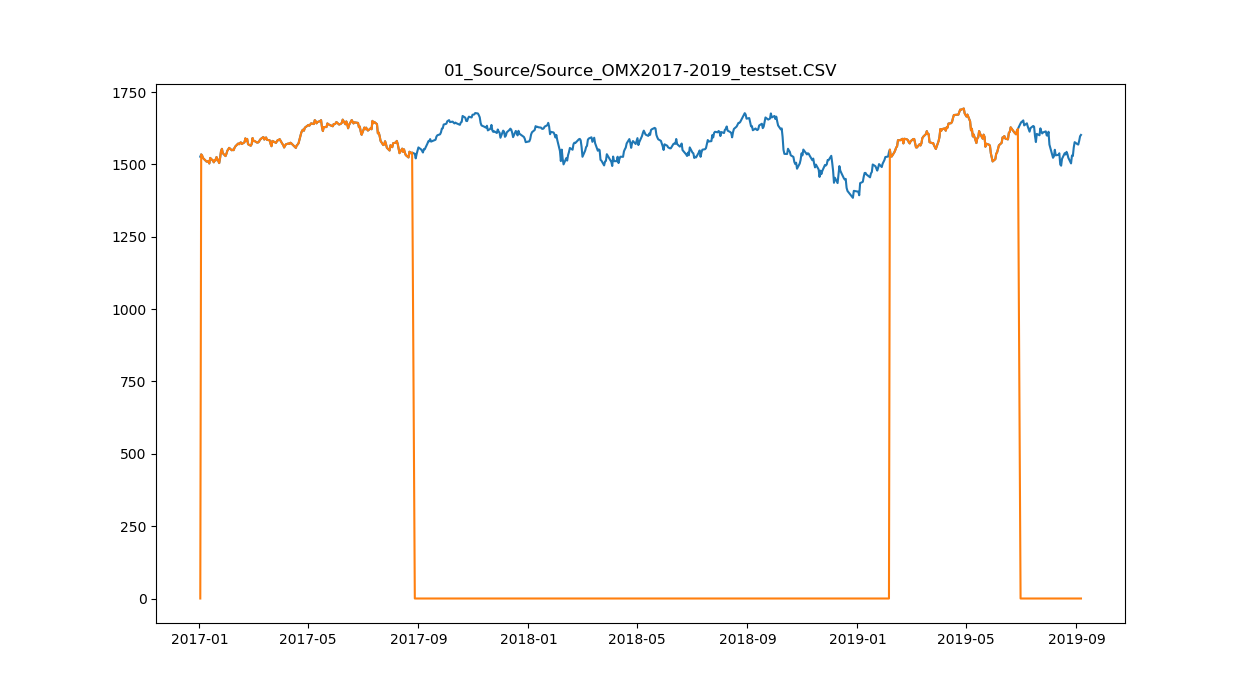

In [65]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'],amplifyForPlot(merged_df['LongTrend'], df['Close'], 0.00))
plt.title(filename)
plt.show()

## Generate Features from Raw Data
Generate features based on price data X

In [66]:
#Inputs
close = merged_df['Close']
high = merged_df['High']
low = merged_df['Low']
yCol = merged_df['LongTrend'];

In [67]:
#Technical indicators necessary
SMA200 = MA(close, 200, 0)
#bollinger = indicators(priceCol,'boll');
#rsi7=calc_RSI(priceCol,7)/100;
#rsi7 = [zeros(7,1);rsi7'];
#SMA200.fillna(0, inplace=True)
#SMA200

features = pd.DataFrame(index=merged_df.index)

### Generate mean values

In [68]:
# Generate features - Mean value 
meanList = [2, 5, 10, 18, 20, 40, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400];
#meanList = [5 10 20 50 100 1 50 200]';
#meanList = [5, 10, 20, 50, 100, 200];
#meanList = [5]

meanfeatures = pd.DataFrame(index=merged_df.index)

for i in meanList:
    #Mean
    meanCol=MA(close, i, 0); #Trailing MA with i
    #meanCol.fillna(0, inplace=True)
    meanColreshaped = np.reshape(meanCol.values, (1,np.product(meanCol.values.shape)))[0]
    #Calculate diff from price in %
    diffPriceCol = np.divide(meanColreshaped - close.values, close.values)
    temp_df = pd.DataFrame(diffPriceCol, columns=['MA' + str(i) + 'Norm'])
    #print(temp_df)
    meanfeatures = meanfeatures.join(temp_df)
    #meanTable(:,i) = diffPriceCol;
    #print("Calculated MA{}".format(i));
display(meanfeatures.head())

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MA175Norm,MA200Norm,MA225Norm,MA250Norm,MA275Norm,MA300Norm,MA325Norm,MA350Norm,MA375Norm,MA400Norm
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.002564,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.001231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.002901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.004067,0.009972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate mean value directions

In [69]:
#Create empty dataframe for the differences between the current time and previous time
madiff_features = pd.DataFrame(index=features.index)

for col in meanfeatures.columns:
    currentCol = meanfeatures[col]
    shiftCol = meanfeatures[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    madiff_features = madiff_features.join(diff)
display(madiff_features.head())

,MA2NormDiff,MA5NormDiff,MA10NormDiff,MA18NormDiff,MA20NormDiff,MA40NormDiff,MA50NormDiff,MA75NormDiff,MA100NormDiff,MA125NormDiff,...,MA175NormDiff,MA200NormDiff,MA225NormDiff,MA250NormDiff,MA275NormDiff,MA300NormDiff,MA325NormDiff,MA350NormDiff,MA375NormDiff,MA400NormDiff
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.003795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Generate RSI

In [70]:
from talib import RSI

rsiList = [2, 5, 14, 20, 25];

rsi_features = pd.DataFrame(index=features.index)

for i in rsiList:
    #RSI
    rsiCol=RSI(close, timeperiod=i)
    #Make df
    temp_df = pd.DataFrame(rsiCol, columns=['RSI' + str(i)])
    #print(temp_df)
    rsi_features = rsi_features.join(temp_df)
    #print("Calculated RSI{}".format(i))
display(rsi_features.head(10))

,RSI2,RSI5,RSI14,RSI20,RSI25
id,,,,,
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,67.611684,NaN,NaN,NaN,NaN
3,26.860068,NaN,NaN,NaN,NaN
4,10.035705,NaN,NaN,NaN,NaN
5,12.447257,24.651726,NaN,NaN,NaN
6,35.405603,29.433454,NaN,NaN,NaN
7,10.084494,21.331757,NaN,NaN,NaN
8,78.597500,55.555636,NaN,NaN,NaN


### Generate Stochastic

In [71]:
from talib import STOCH

slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)

stoch_features = pd.DataFrame(index=features.index)
stoch_features = stoch_features.join(pd.DataFrame(slowk, columns=['Stoch_slowk13']))
stoch_features = stoch_features.join(pd.DataFrame(slowd, columns=['Stoch_slowd8']))
display(stoch_features.head(30))

,Stoch_slowk13,Stoch_slowd8
id,,
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,NaN,NaN
7,NaN,NaN
8,NaN,NaN


### MACD

In [72]:
from talib import MACDEXT

#MACD
macd, macdsignal, macdhist = MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
macd_features = pd.DataFrame(index=features.index)
macd_features = macd_features.join(pd.DataFrame(macd, columns=['MACD12_26_9']))
display(macd_features.iloc[30:40])

,MACD12_26_9
id,
30,NaN
31,NaN
32,NaN
33,18.753333
34,18.722564
35,18.488077
36,18.379936
37,18.712115
38,18.278910


In [73]:
#MACD direction
#Create empty dataframe for the differences between the current time and previous time
macd_diff_features = pd.DataFrame(index=features.index)

for col in macd_features.columns:
    currentCol = macd_features[col]
    shiftCol = macd_features[col].shift(1)
    diff = currentCol-shiftCol
    diff.name = col + 'Diff'
    #display(currentCol)
    #display(shiftCol)
    macd_diff_features = macd_diff_features.join(diff)
display(macd_diff_features.iloc[30:40])

,MACD12_26_9Diff
id,
30,NaN
31,NaN
32,NaN
33,NaN
34,-0.030769
35,-0.234487
36,-0.108141
37,0.332179
38,-0.433205


### Signals for Trigger

In [74]:
def generate_smoothed_trigger(values):
    ''' From a value array with signals in the range -1, 0, 1, generate smoothed decay'''
    
    smoothed_sign_change = np.zeros(values.shape)
    for i, value in enumerate(values):
        previous_value = 0.0
        if i>0:
            previous_value = smoothed_sign_change[i-1]
        if np.isnan(value):
            value = 0
        
        #Now use expoential smoothing to smooth the values 
        def exponential_smoothing(current_value, previous_value, alpha=0.5, tailclip=0.1):
            new_value = current_value + (1-alpha) * previous_value
            if current_value==1 or current_value ==-1:
                new_value = current_value
            
            if new_value<-1:
                newValue = -1
            elif new_value>1:
                new_value = 1
            elif np.abs(new_value)<tailclip:
                new_value = 0
            
            return new_value
        
        smoothed_sign_change[i] = np.round(exponential_smoothing(value, previous_value, alpha=0.4, tailclip=0.1), 3)
        #print("new val: {}, Val: {}, prev val: {}".format(smoothed_sign_change[i], value, previous_value))
    
    return smoothed_sign_change
    

In [75]:
#If MACD changes direction
macd_direction_change_features = pd.DataFrame(index=features.index)

for col in macd_diff_features.columns:
    #Column to find signal on
    currentCol = macd_diff_features[col]
    #Other column, here the same column shifted to find out if the direction changes
    shiftCol = macd_diff_features[col].shift(1)
    
    display(currentCol.iloc[90:100])
    #display(shiftCol.iloc[30:60])
    
    #Multiply current diff with previous diff and get the sign of the product. If sign is negative, then direction change
    #has occured. The multiply with the sign of the current value to get the sign of the direction change. If 1, then
    #it was a change from negative to positive. If it was negative, then it was a change from negative to positive
    signChange = (np.sign(currentCol*shiftCol)==-1)*1*np.sign(currentCol)
    display(signChange[90:100])
    
    smoothed_sign_change = generate_smoothed_trigger(signChange)
    macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))
    
macd_direction_change_features.iloc[90:100]

id
90   -0.436154
91   -0.711282
92   -0.594615
93   -2.358846
94   -3.523846
95   -2.580641
96   -3.002308
97   -2.592500
98   -2.591538
99   -4.466538
Name: MACD12_26_9Diff, dtype: float64

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sign
  app.launch_new_instance()


id
90   -1.0
91   -0.0
92   -0.0
93   -0.0
94   -0.0
95   -0.0
96   -0.0
97   -0.0
98   -0.0
99   -0.0
Name: MACD12_26_9Diff, dtype: float64

,MACD12_26_9DiffDirChange
id,
90,-1.000
91,-0.600
92,-0.360
93,-0.216
94,-0.130
95,0.000
96,0.000
97,0.000
98,0.000


### Generate RSI5 Signal
If RSI5 < 50, then the probability is high that it goes < 20 too and the price is lower

In [76]:
rsi5=RSI(close, timeperiod=5)
#Other column, here the same column shifted to find out if the direction changes
rsi5shift = rsi5.shift(1)
display(rsi5.iloc[0:20])
display(rsi5shift.iloc[0:20])

rsi5_change = pd.DataFrame(index=features.index)

#rsi5_change = (rsi5<50 and rsi5shift>50)
#display(rsi5_change[0:20])
    
#rsi5_change_smoothed = generate_smoothed_trigger(rsi5_change)
#macd_direction_change_features = macd_direction_change_features.join(pd.Series(data=smoothed_sign_change, name=col + 'DirChange'))
    
#macd_direction_change_features.iloc[90:100]



id
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5     24.651726
6     29.433454
7     21.331757
8     55.555636
9     43.747499
10    37.788961
11    50.675348
12    47.725015
13    62.840379
14    38.090214
15    56.701449
16    70.720903
17    74.275414
18    57.549627
19    48.621540
dtype: float64

id
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6     24.651726
7     29.433454
8     21.331757
9     55.555636
10    43.747499
11    37.788961
12    50.675348
13    47.725015
14    62.840379
15    38.090214
16    56.701449
17    70.720903
18    74.275414
19    57.549627
dtype: float64

In [77]:
rsi5shift

id
0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6      24.651726
7      29.433454
8      21.331757
9      55.555636
10     43.747499
11     37.788961
12     50.675348
13     47.725015
14     62.840379
15     38.090214
16     56.701449
17     70.720903
18     74.275414
19     57.549627
20     48.621540
21     55.494516
22     63.658743
23     66.919891
24     70.852004
25     57.656630
26     59.919931
27     56.759653
28     67.250303
29     72.525867
         ...    
643    49.061839
644    52.800186
645    39.055974
646    38.626288
647    55.402897
648    25.762767
649    17.081245
650    14.836294
651    20.425062
652    41.341298
653    32.303365
654    33.762799
655    39.549047
656    22.369847
657    21.075861
658    43.380731
659    56.161934
660    52.645588
661    58.976700
662    51.476379
663    41.088054
664    29.688576
665    52.812884
666    51.506484
667    68.612080
668    75.316457
669    68.507380
670    66.8

### Periodical indicators

In [78]:
periodic_values = pd.DataFrame(index=features.index)
timelist = df['Time']
# Get month of year
periodic_values['month_of_year'] = timelist.apply(lambda x: x.month)
# Get week of year
periodic_values['week_of_year'] = timelist.apply(lambda x: x.week)
# Get day of year
periodic_values['day_of_year'] = timelist.apply(lambda x: x.timetuple().tm_yday)
# Get day of month
periodic_values['day_of_month'] = timelist.apply(lambda x: x.day)
# Get day of week
periodic_values['day_of_week'] = timelist.apply(lambda x: x.weekday())

display(periodic_values.head())

,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,
0,1,1,2,2,0
1,1,1,3,3,1
2,1,1,4,4,2
3,1,1,5,5,3
4,1,2,9,9,0


### Merge all feature columns

In [79]:
features = pd.DataFrame(index=merged_df.index)
features = features.join(meanfeatures)
features = features.join(madiff_features)
features = features.join(rsi_features)
features = features.join(stoch_features)
features = features.join(macd_features)
features = features.join(macd_diff_features)
features = features.join(macd_direction_change_features)
features = features.join(periodic_values)
display(features.head(100))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowk13,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,1,2,2,0
1,-2.564019e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,1,3,3,1
2,1.231278e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,1,4,4,2
3,2.900598e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,1,5,5,3
4,4.066710e-03,0.009972,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,2,9,9,0
5,-8.939865e-05,0.007574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,2,10,10,1
6,-5.919782e-04,0.003363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,2,11,11,2
7,2.850377e-03,0.005408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,2,12,12,3
8,-6.298892e-03,-0.007207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,1,2,13,13,4


### Clean NaNs and Merge X and y

In [80]:
#Assign the columns to X and y
#Clean the featurestable and make an array or it
#Drop all NaN rows
nan_index = pd.isnull(features).any(1).nonzero()[0]
print("Found {} rows with NaN".format(len(nan_index)))
X=features.drop(nan_index)
#yName = 'LongTrend'
y=merged_df.drop(nan_index).drop(['Time', 'High', 'Low', 'Close'], axis=1)

#Merge X and y to one chart
dataset = X.join(y)

graphsource = df.drop(nan_index)
#y=y.reshape(-1, 1)

#Create the matrix with features
#featureNames = features.columns.values

print("Got features X shape={}, y shape={}".format(X.shape, y.shape))
print("Dataset shape", dataset.shape)

Found 400 rows with NaN
Got features X shape=(273, 57), y shape=(273, 4)
Dataset shape (273, 61)


In [81]:
display(dataset.head(5))
display(dataset.tail(5))
display(graphsource.head(5))
display(graphsource.tail(5))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
400,-0.003522,-0.005992,-0.006573,-0.016782,-0.020412,-0.031975,-0.032452,-0.027211,-0.033875,-0.035074,...,0.00,8,32,219,7,1,0,0,1,0
401,-0.000844,-0.006427,-0.006441,-0.015985,-0.019097,-0.032834,-0.033579,-0.028324,-0.035232,-0.036156,...,0.00,8,32,220,8,2,0,0,1,0
402,-0.002636,-0.007598,-0.010304,-0.018500,-0.021519,-0.037011,-0.037952,-0.032968,-0.040037,-0.040844,...,-1.00,8,32,221,9,3,0,0,1,0
403,0.004456,0.001849,-0.001233,-0.007684,-0.010759,-0.027983,-0.028706,-0.024109,-0.031330,-0.031816,...,-0.60,8,32,222,10,4,0,1,1,0
404,0.001557,0.005382,0.001923,-0.003167,-0.005846,-0.024314,-0.024914,-0.020768,-0.028075,-0.028246,...,-0.36,8,33,225,13,0,0,1,1,0


,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
668,0.002162,-0.010839,-0.018870,-0.022996,-0.023535,-0.000299,0.007609,0.007031,0.016681,0.015258,...,0.13,9,36,245,2,0,0,0,0,0
669,0.000488,-0.005049,-0.015726,-0.021404,-0.021129,-0.000315,0.008099,0.007616,0.017316,0.016151,...,0.00,9,36,246,3,1,0,0,0,0
670,-0.003990,-0.006394,-0.021190,-0.027466,-0.027262,-0.008945,-0.000237,-0.000642,0.008974,0.008007,...,0.00,9,36,247,4,2,0,0,0,0
671,-0.005027,-0.011550,-0.027160,-0.035008,-0.035580,-0.019157,-0.010534,-0.010619,-0.001366,-0.002004,...,0.00,9,36,248,5,3,0,0,0,0
672,-0.001439,-0.011278,-0.025022,-0.035586,-0.036157,-0.022349,-0.013637,-0.013474,-0.004396,-0.004661,...,0.00,9,36,249,6,4,0,0,0,0


,Time,High,Low,Close
id,,,,
400,2018-08-07,1621.26,1610.52,1619.89
401,2018-08-08,1624.10,1614.73,1622.63
402,2018-08-09,1631.74,1618.72,1631.23
403,2018-08-10,1627.44,1613.39,1616.82
404,2018-08-13,1616.34,1607.81,1611.80


,Time,High,Low,Close
id,,,,
668,2019-09-02,1582.91,1568.70,1570.19
669,2019-09-03,1575.98,1563.07,1568.66
670,2019-09-04,1586.23,1569.31,1581.28
671,2019-09-05,1598.04,1581.92,1597.34
672,2019-09-06,1602.36,1593.87,1601.95


In [82]:
y_labels = {
    'negative' : 0,
    'positive' : 1
}

In [83]:
import csv

#Save dataset to a csv file
print("dataset shape {}".format(dataset.shape))
dataset.to_csv(dataset_filename, sep=';', index=True, header=True)
#np.savetxt(filenameprefix + "_y.csv", y, delimiter=";", fmt='%s')
print("Saved features to " + dataset_filename)

#Save the graph data for visualization of the results
print("source shape {}".format(graphsource.shape))
graphsource.to_csv(source_filename, sep=';', index=True, header=True)
#np.savetxt(filenameprefix + "_y.csv", y, delimiter=";", fmt='%s')
print("Saved source graph to " + source_filename)

#Save y labels to a csv file as a dict
print("Class labels length {}".format(len(y_labels)))
with open(ylabel_filename, 'w') as f:
    for key in y_labels.keys():
        f.write("%s;%s\n"%(key,y_labels[key]))
print("Saved class names and id to " + ylabel_filename)

print("=== Data for {} prepared to be trained ===". format(filenameprefix))

dataset shape (273, 61)
Saved features to 03_Test_Prepared_Data/omxs30_test_dataset.csv
source shape (273, 4)
Saved source graph to 03_Test_Prepared_Data/omxs30_test_timegraph.csv
Class labels length 2
Saved class names and id to 03_Test_Prepared_Data/omxs30_test_y_labels.csv
=== Data for omxs30_test prepared to be trained ===


# Debug and Experiment

## Lowess Estimation of the Main Trend

In [84]:
from statsmodels.nonparametric.smoothers_lowess import lowess

#df['Time'],df['Close']
#print(len(df['Close']))
frac=300/len(df['Close'])
filtered = lowess(df['Close'], df['Time'], frac=frac)
#frac2=50/len(df['Close'])
#filtered2 = lowess(filtered[:,1], df['Time'], frac=frac2)

In [85]:
#def amplifyForPlot(binaryArray, targetArray, distance):
#    return binaryArray * targetArray * (1-distance)

In [86]:
import numpy as np
from scipy.ndimage.interpolation import shift

shiftCol = filtered[:,1] - shift(filtered[:,1], 1, cval=np.NaN)
pos_trend = shiftCol>0
pos_trend
#squarer = lambda x: x
#vfunc = np.vectorize(squarer)
#vfunc(x)
#np.mapp([filtered[:, 1]*[len(shiftCol>0)

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

<IPython.core.display.Javascript object>


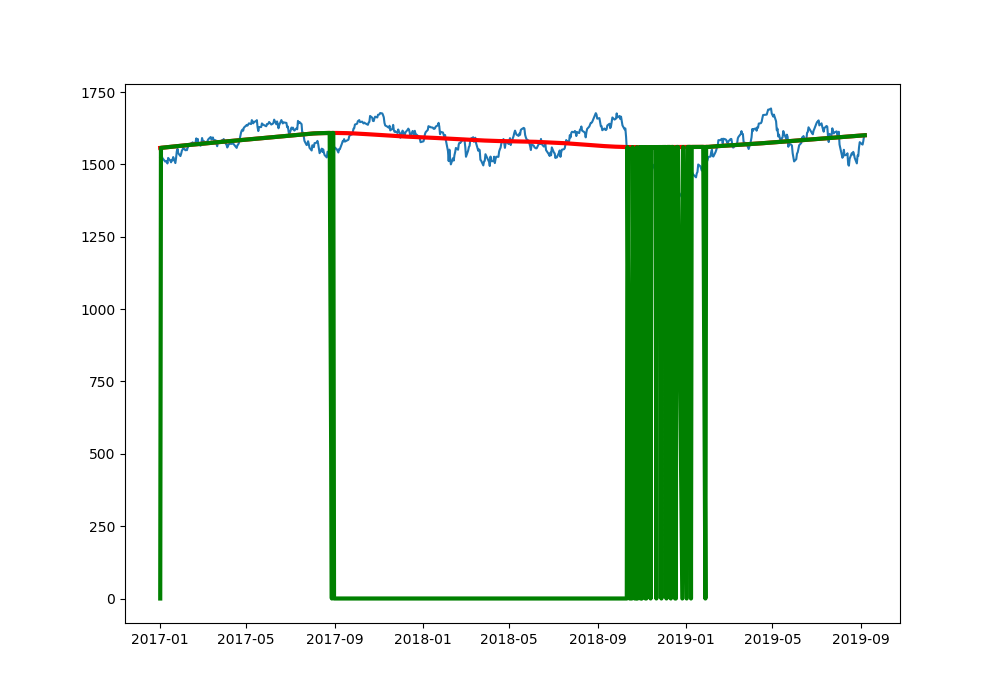

In [87]:
plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df['Time'],df['Close'])
plt.plot(df['Time'], filtered[:, 1], 'r-', linewidth=3)
plt.plot(df['Time'], filtered[:, 1]*pos_trend, 'g-', linewidth=3)
#plt.plot(df['Time'], filtered[:, 1]*pos_trend_cleaned, 'y-', linewidth=3)

plt.show()

In [88]:
len(filtered[:, 1])

673

In [89]:
from talib import RSI, BBANDS, MACDEXT, STOCH, STOCHF

#RSI
rsi = RSI(df['Close'], timeperiod=14)
display(rsi[0:20])
#Bollinger Bands
up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
display(up[0:20])
#MACD
macd, macdsignal, macdhist = MACDEXT(close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
display(macd[20:40])
#Stockastics slow
slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
display(slowk[20:40])
#Stochastics fast
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)
display(fastk[20:40])

id
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13          NaN
14    40.839126
15    49.080081
16    57.251477
17    59.633148
18    53.486969
19    49.875625
dtype: float64

id
0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19    1549.119457
dtype: float64

id
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
30          NaN
31          NaN
32          NaN
33    18.753333
34    18.722564
35    18.488077
36    18.379936
37    18.712115
38    18.278910
39    17.367692
dtype: float64

id
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
dtype: float64

id
20          NaN
21          NaN
22          NaN
23          NaN
24          NaN
25          NaN
26          NaN
27          NaN
28          NaN
29          NaN
30          NaN
31          NaN
32          NaN
33          NaN
34          NaN
35          NaN
36          NaN
37          NaN
38    75.349613
39    68.829566
dtype: float64

<IPython.core.display.Javascript object>


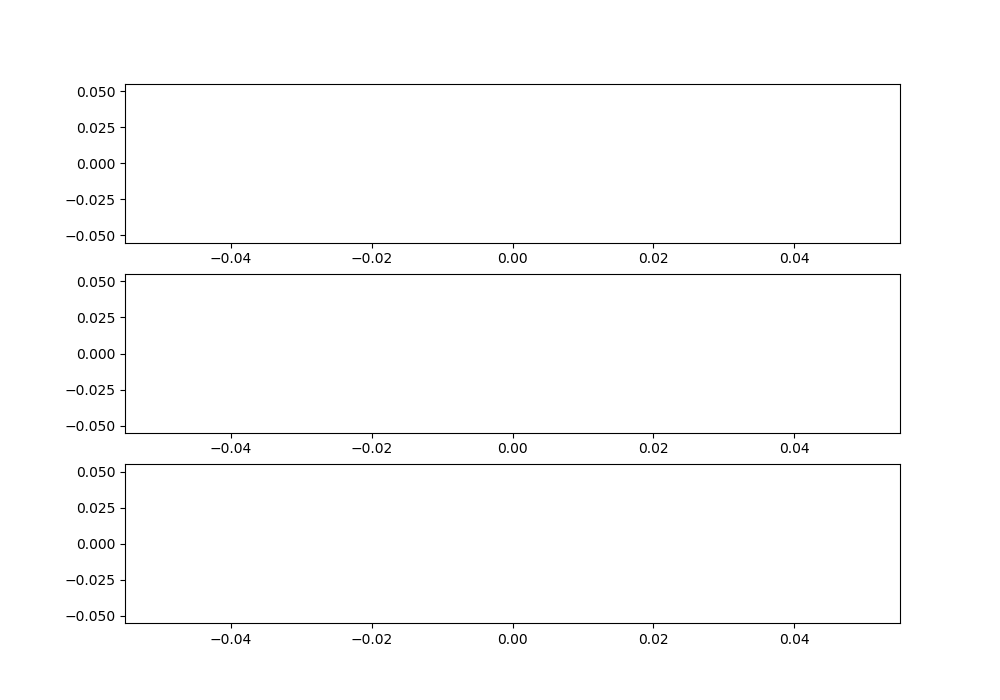

In [90]:
slowk, slowd = STOCH(high, low, close, fastk_period=13, slowk_period=3, slowk_matype=0, slowd_period=8, slowd_matype=0)
fastk, fastd = STOCHF(high, low, close, fastk_period=13, fastd_period=8, fastd_matype=0)

plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.plot(df['Time'][8000:-1],df['Close'][8000:-1])

plt.subplot(312)
plt.plot(df['Time'][8000:-1],slowk[8000:-1])
plt.plot(df['Time'][8000:-1],slowd[8000:-1])

plt.subplot(313)
plt.plot(df['Time'][8000:-1],fastk[8000:-1])
plt.plot(df['Time'][8000:-1],fastd[8000:-1])
#plt.plot(df['Time'][0:500],fastk[0:500])
#plt.plot(df['Time'][0:500],fastd[0:500])